Fix the seeds

In [1]:
import random
import torch
import numpy as np

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [2]:
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Let's create Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel measurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  False 



Here are the functions, which create measurements vectror for all patterns in Hadamard basis

In [3]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten()).to(device)
    M = (Mplus - Mminus)

    return M

In [4]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Out dataset with single pixel measuarements and their class labels

In [5]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MeasurementsDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        
        self.labels = mnist.targets
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize((px,px))])

        images = transform(mnist.data)
        self.target_images = (images - images.min()) / (images.max() - images.min())

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.labels[indx]

    def __len__(self):
        return len(self.measurements)

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MeasurementsDataset(MNIST(root='./data', train=True, download=True))
test_set = MeasurementsDataset(MNIST(root='./data', train=False, download=True))

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [7]:
variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [8]:
most_important = np.argsort(variance)[-64:]

# Model

Model characteristics

In [9]:
import pennylane as qml

num_classes = 10
feature_size = 64
# number of qubits - logarithm of numbers of features
num_qubits = int(np.ceil(np.log2(feature_size)))

num_layers = 30
margin = 0.15

lr_adam = 0.001
num_epochs = 6

dev = qml.device("lightning.qubit", wires=num_qubits, batch_obs=True)

Let's create variational quantum circuit

In [10]:
def layer(W, flag=None):
    for i in range(num_qubits):
        qml.RY(W[i], wires=i)
    if (flag == None): # add last layer without entangling gates
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j + 1])

In [11]:
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)
    qml.Barrier(list(range(num_qubits))) # for drawing
    
    for i, W in enumerate(weights):
        if i < len(weights) - 1:
            layer(W)
        else:
            layer(W, 'last')
        qml.Barrier(list(range(num_qubits)))

    return qml.expval(qml.PauliZ(0)) # observable

# for ten different classifiers
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

In [12]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

How one classifier looks like

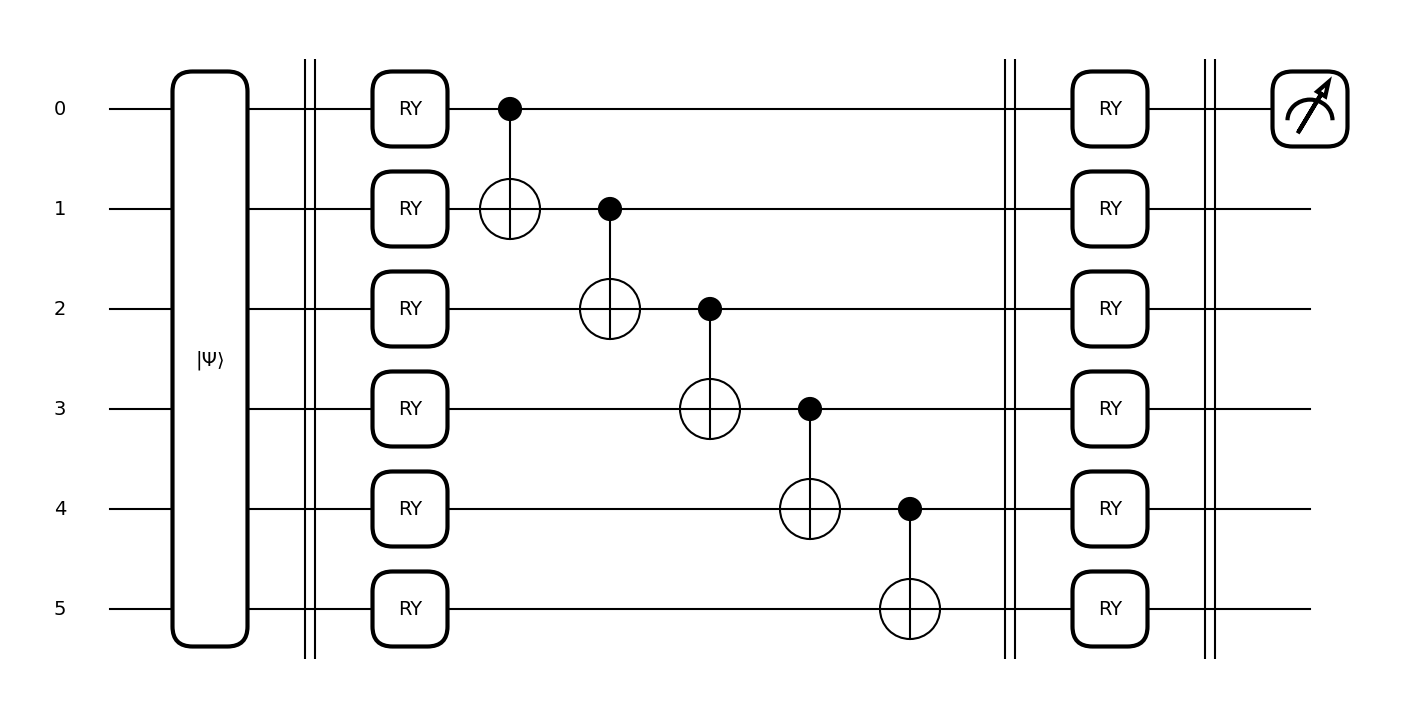

In [13]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

all_weights = Variable(0.1 * torch.randn(1 + 1, num_qubits), requires_grad=True)
all_bias = Variable(0.1 * torch.ones(1), requires_grad=True)
params = (all_weights, all_bias)

fig, ax = qml.draw_mpl(circuit)(params[0], params[1])
plt.show()

Margin loss for the results of ten classifiers

In [14]:
def margin_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        feature_vec = feature_vec.to(device)

        # Let's calculate the score assigned to this sample by the classifier corresponding to the true label
        s_true = variational_classifier(q_circuits[int(true_labels[i])],
                                        (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
                                        feature_vec)
        s_true = s_true.float()

        # Let's get values for the wrong classes
        li = 0
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(q_circuits[j],
                                            (all_params[0][j], all_params[1][j]),
                                             feature_vec)
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).to(device).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

In [15]:
def classify(q_circuits, all_params, feature_vecs):
    predicted_labels = []
    for feature_vec in feature_vecs:
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(q_circuits[c],
                                           (all_params[0][c], all_params[1][c]),
                                           feature_vec)
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels


def accuracy(labels, hard_predictions):
    acc = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            acc += 1
    acc = acc / labels.shape[0]
    return acc

Class for plots

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [17]:
def to_device_(list_of_tensors, device):
    for tensor in list_of_tensors:
        tensor = tensor.to(device)
    return list_of_tensors

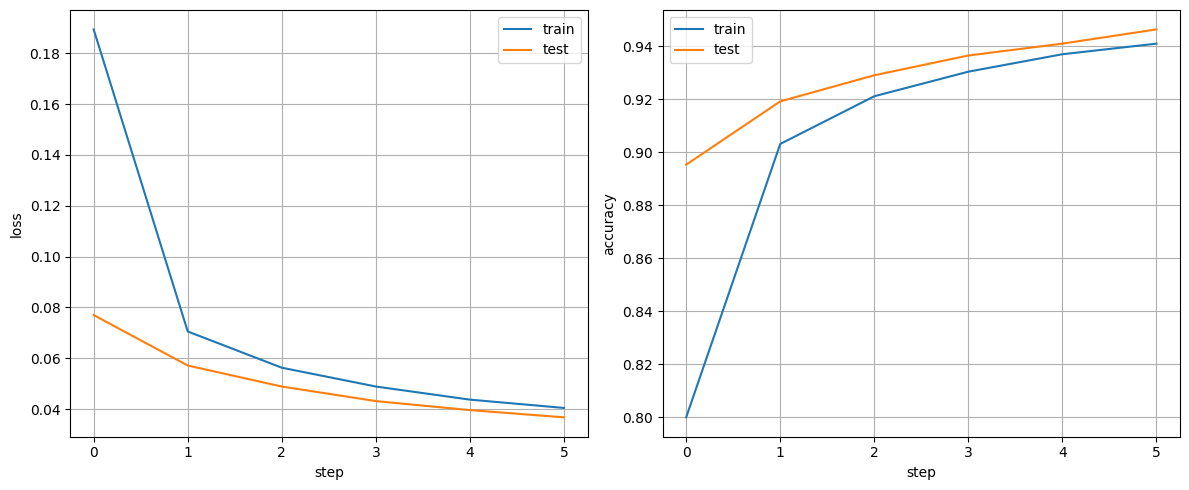

CPU times: total: 2d 16h 46min 12s
Wall time: 2d 15h 22min 40s


In [20]:
%%time

from torch.autograd import Variable
import torch.optim as optim

pp = ProgressPlotter(groups=['loss', 'accuracy'])

q_circuits = qnodes

# Random parameters initialization
all_weights = to_device_([Variable(0.1 * torch.randn(num_layers + 1, num_qubits).to(device), requires_grad=True) for i in range(num_classes)], device)
all_bias = to_device_([Variable(0.1 * torch.ones(1).to(device), requires_grad=True) for i in range(num_classes)], device)

optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)

params = (all_weights, all_bias)
print("Num params: ", num_classes * (num_qubits * (num_layers + 1) + 1))

for e in range(num_epochs):
    loss_train = 0
    acc_train = 0
    for i, batch in enumerate(train_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)

        optimizer.zero_grad()

        curr_cost = margin_loss(q_circuits, params, x, labels)
        l = curr_cost.detach().cpu().numpy()[0]
        print(l, file=open(f"logs/loss_{e}_6lays_001lr.txt", "a+"))
        loss_train += l

        pred = classify(q_circuits, params, x)
        a = accuracy(labels, pred)
        print(a, file=open(f"logs/acc_{e}_6lays_001lr.txt", "a+"))
        acc_train += a
        
        curr_cost.backward()
        optimizer.step()

        print(f"Train: Epoch {e}, batch #{i+1}/{len(train_loader)}, loss={l}")

    loss_train /= len(train_loader)
    acc_train /= len(train_loader)

    loss_val = 0
    acc_val = 0
    for i, batch in enumerate(test_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)

        curr_cost = margin_loss(q_circuits, params, x, labels)
        l = curr_cost.detach().cpu().numpy()[0]
        print(l, file=open(f"logs/loss_val_{e}_6lays_001lr.txt", "a+"))
        loss_val += l

        pred = classify(q_circuits, params, x)
        a = accuracy(labels, pred)
        print(a, file=open(f"logs/acc_val_{e}_6lays_001lr.txt", "a+"))
        acc_val += a

        print(f"Validation: Epoch {e}, batch #{i+1}/{len(test_loader)}, accuracy={a}")

    loss_val /= len(test_loader)
    acc_val /= len(test_loader)

    pp.add_scalar('loss', loss_train, 'train')
    pp.add_scalar('loss', loss_val, 'test')

    pp.add_scalar('accuracy', acc_train, 'train')
    pp.add_scalar('accuracy', acc_val, 'test')
    
    pp.display()

In [21]:
print(pp.history_dict["loss"]["train"])

[0.1894275714764431, 0.07052421187564953, 0.056258237757868985, 0.04885508784893225, 0.0436952093532726, 0.040426787627892674]


In [22]:
print(pp.history_dict["loss"]["test"])

[0.07698042164882941, 0.05712560530170609, 0.0488510329519535, 0.04312058019223415, 0.0395763580743698, 0.03673265894851203]


In [23]:
print(pp.history_dict["accuracy"]["train"])

[0.7999400319829424, 0.9031183368869936, 0.9211253997867804, 0.9304037846481876, 0.9369836087420043, 0.9409814765458422]


In [24]:
print(pp.history_dict["accuracy"]["test"])

[0.8953025477707006, 0.919187898089172, 0.9290406050955414, 0.9365047770700637, 0.9409832802547771, 0.9463574840764332]
